In [1]:
import os
import sys

import pandas as pd
import numpy as np
import random
import itertools

from matplotlib import pyplot as plt

from tqdm import tqdm

from pandarallel import pandarallel

import pymorphy2
import nltk
import pickle
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.phrases import Phrases, Phraser

import time


SEED = 1
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed(SEED)
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
abbr = pd.read_csv("../data/abbr.csv")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [26]:
abbr_pos = abbr["abbr_norm"].to_list()
labels = [1] * len(abbr_pos)

desc_norm_list = abbr["desc_norm"].to_list()
abbr_neg = []
for desc in desc_norm_list:
    abbr_neg.extend(desc.split(" "))

texts = lenta_train["text_norm"].to_list()
random.shuffle(texts)
for text in tqdm(texts[:len(abbr_neg) * 4]):
    words = text.split(" ")
    random.shuffle(words)
    abbr_neg.extend(words[:1])
labels.extend([0] * len(abbr_neg))

abbr_data = abbr_pos + abbr_neg
len(abbr_data), np.array(labels).mean()

100%|██████████| 39144/39144 [00:01<00:00, 25724.65it/s]


(54555, 0.10310695628265054)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(abbr_data, labels, shuffle=True, test_size=0.2)

y_train = torch.Tensor(y_train).long()
y_test = torch.Tensor(y_test).long()

In [28]:
PAD_TOKEN = "<PAD>"
PAD_TOKEN_ID = 0
UNIQUE_TOKENS = [PAD_TOKEN] + list(set("".join(X_train)))
tokens_num = len(UNIQUE_TOKENS)

token2id = {label: i for i, label in enumerate(UNIQUE_TOKENS)}
id2token = {i: label for label, i in token2id.items()}

max_size = 0
for word in X_train:
    max_size = max(len(word), max_size)

In [29]:
def tokenize(word, max_size):
    tokens = list(map(lambda x: token2id.get(x, 0), list(word)))
    tokens = tokens[:max_size] + [PAD_TOKEN_ID] * (max_size - len(tokens))
    return tokens

def get_tokenized_data(data):
    tokenized = []
    max_size = 27
    for line in data:
        if line:
            tokens = tokenize(line, max_size=max_size)
            tokenized.append(tokens)
    return torch.Tensor(tokenized).long()

X_train = get_tokenized_data(X_train)
X_test = get_tokenized_data(X_test)

In [30]:
class StackedConv1d(nn.Module):
    def __init__(self, features_num, layers_n=1, kernel_size=3, dropout=0.0):
        super().__init__()
        layers = []
        for _ in range(layers_n):
            conv_block = nn.Sequential(
                nn.Conv1d(
                    features_num, 
                    features_num, 
                    kernel_size, 
                    padding=kernel_size//2 
                ),
                nn.Dropout(dropout),
                nn.LeakyReLU()
            )
            layers.append(conv_block)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        """x - BatchSize x FeaturesNum x SequenceLen"""
        for layer in self.layers:
            x = x + layer(x) 
        return x

class AbbrDetection(nn.Module): 
    def __init__(self, tokens_num, labels_num, embedding_size=64, layers_n=3, kernel_size=3, dropout=0.1):
        super().__init__()
        self.embeddings = nn.Embedding(tokens_num, embedding_size, padding_idx=0)
        
        self.backbone = StackedConv1d(embedding_size, layers_n=3, kernel_size=3, dropout=0.1)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Linear(embedding_size, labels_num)
        self.labels_num = labels_num
    
    def forward(self, tokens):
        """tokens - BatchSize x MaxSentenceLen x MaxTokenLen"""
        batch_size, max_sent_len = tokens.shape

        char_embeddings = self.embeddings(tokens)  # BatchSize x MaxSentenceLen x EmbSize
        char_embeddings = char_embeddings.permute(0, 2, 1)
        
        features = self.backbone(char_embeddings) # BatchSize x EmbSize x MaxTokenLen
        global_features = self.global_pooling(features).squeeze(-1)
        
        logits = self.out(global_features)
        
        return logits

In [31]:
model         = AbbrDetection(tokens_num=tokens_num, 
                               labels_num=2, 
                               embedding_size=16, 
                               layers_n=3,
                               kernel_size=3,
                               dropout=0.2)
loss_function = F.cross_entropy 
optimizer     = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
for t in model.parameters():
    print(t.shape)

print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

torch.Size([71, 16])
torch.Size([16, 16, 3])
torch.Size([16])
torch.Size([16, 16, 3])
torch.Size([16])
torch.Size([16, 16, 3])
torch.Size([16])
torch.Size([2, 16])
torch.Size([2])
Количество параметров 3522


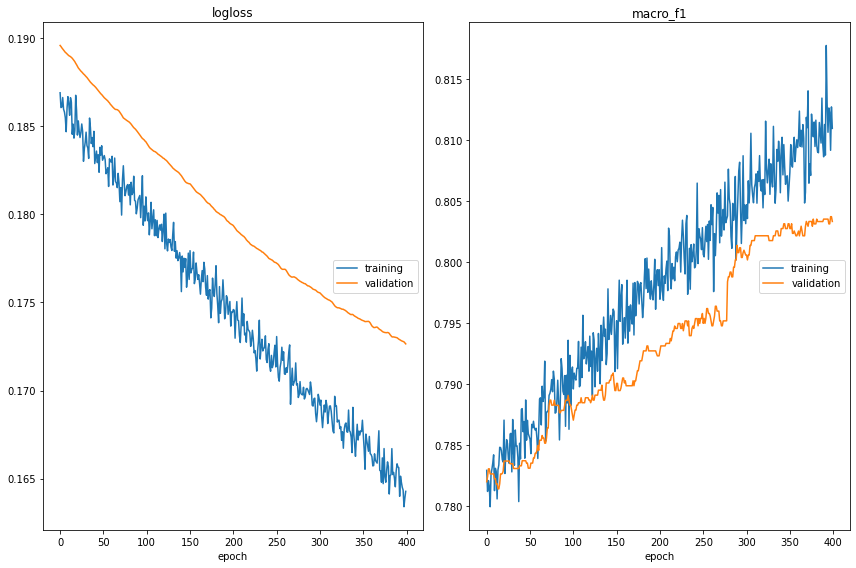

logloss
	training         	 (min:    0.163, max:    0.187, cur:    0.164)
	validation       	 (min:    0.173, max:    0.190, cur:    0.173)
macro_f1
	training         	 (min:    0.780, max:    0.818, cur:    0.811)
	validation       	 (min:    0.781, max:    0.804, cur:    0.803)


In [36]:
from livelossplot import PlotLosses

def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

def get_f1_score(batch_y, pred):
    pred_argmax = pred.argmax(1).cpu().detach().numpy().reshape(-1)
    batch_y = batch_y.cpu().detach().numpy().reshape(-1)
    return f1_score(batch_y, pred_argmax, average="macro")
    
liveplot = PlotLosses(groups={"logloss": ["train_logloss", "val_logloss"], 
                              "macro_f1": ["train_f1", "val_f1"]})
epoch_n = 400

device = torch.device("cuda")
model.to(device)

for epoch_i in range(epoch_n):
    model.train()
    loss_sum = 0
    f1_sum = 0
    batch_n = 1      
    
    batch_x = copy_data_to_device(X_train, device)
    batch_y = copy_data_to_device(y_train, device)        

    pred = model(batch_x)
    loss = loss_function(pred, batch_y)

    model.zero_grad() 
    loss.backward() 
    optimizer.step()

    loss_sum = float(loss)
    f1_sum = float(get_f1_score(batch_y, pred))

    model.eval()
    val_loss_sum = 0
    val_f1_sum = 0
    val_batch_n = 1
    with torch.no_grad():

        batch_x = copy_data_to_device(X_test, device)
        batch_y = copy_data_to_device(y_test, device)        

        pred = model(batch_x)
        loss = loss_function(pred, batch_y)

        val_loss_sum = float(loss)
        val_f1_sum = float(get_f1_score(batch_y, pred))
    
    liveplot.update({'train_logloss': loss_sum / batch_n, 
                     'val_logloss': val_loss_sum / val_batch_n,
                     'train_f1': f1_sum / batch_n,
                     'val_f1': val_f1_sum / val_batch_n})
    liveplot.draw()